In [34]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [35]:
results_dir = './data/outputs'

name_map = {
    # 'llama_2_7b_hf_mono_merged': 'mono (en)',
    'llama_2_7b_hf_ml1_merged': 'Mono (en)',
    'llama_2_7b_hf_ml2_merged': 'ML2',
    'llama_2_7b_hf_ml3_merged': 'ML3',
    'llama_2_7b_hf_ml4_merged': 'ML4',
    'llama_2_7b_hf_ml5_merged': 'ML5',
    'llama_2_7b_hf_en_merged': 'ML6 (no en)',
    'llama_2_7b_hf_ru_merged': 'ML6 (no ru)',
    'llama_2_7b_hf_de_merged': 'ML6 (no de)',
    'llama_2_7b_hf_zh_merged': 'ML6 (no zh)',
    'alpaca_eval_instructions_de': 'alpaca (de)',
    'alpaca_eval_instructions_ru': 'alpaca (ru)',
    'alpaca_eval_instructions_en': 'alpaca (en)',
    'alpaca_eval_instructions_es': 'alpaca (es)',
    'alpaca_eval_instructions_fr': 'alpaca (fr)',
    'alpaca_eval_instructions_it': 'alpaca (it)',
    'alpaca_eval_instructions_is': 'alpaca (is)',
    'alpaca_eval_instructions_hi': 'alpaca (hi)',
    'alpaca_eval_instructions_el': 'alpaca (el)',
    'alpaca_eval_instructions_zh': 'alpaca (zh)',
}

def load_json(file):
    with open(file, "r", encoding='utf8') as f:
        return json.load(f)

def parse_filename(file):
    """
    data/outputs/llama_2_7b_hf_en_merged/alpaca_eval_instructions_ru-none-guanaco_prompt-s0-k50-p0.9-t0.8-b8.eval
    """
    # get test set and context, allowing for no context
    model_name = Path(file).parent.name
    parts = Path(file).stem.split('-')

    test_set = parts[0]
    context = parts[1]
    prompt = parts[2]
    seed = int(parts[3][1:])
    top_k = int(parts[4][1:])
    top_p = float(parts[5][1:])
    temp = float(parts[6][1:])
    bs = int(parts[7][1:])

    return model_name, test_set, prompt, seed


def get_results(results_dir):
    """
    Collect all eval files in results_dir and parse them into a dataframe
    """
    dfs = []
    for eval_file in Path(results_dir).glob('*/*.eval'):
        # print(eval_file)
        df = pd.read_csv(eval_file, index_col=None)
        model_name, test_set, prompt, seed = parse_filename(eval_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
        # # get generation args too
        # try:
        #     hp_file = eval_file.with_suffix(".json")
        #     hps = load_json(hp_file)
        #     eval_dict.update(hps)
        # except:
        #     pass
    
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    df = df.reindex(columns=cols)

    return df

df = get_results(results_dir)
df.replace({'model_name': name_map, 'test_set': name_map}, inplace=True)
print(len(df))
print(df.columns)
df.head()

168
Index(['model_name', 'test_set', 'seed', 'lang_match', 'tgt_lang', 'ppl',
       'file', 'context'],
      dtype='object')


,model_name,test_set,seed,lang_match,tgt_lang,ppl,file,context
0,Mono (en),alpaca (de),0,0.391,0.390,24.971,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt
1,Mono (en),alpaca (de),42,0.416,0.419,22.476,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt
2,Mono (en),alpaca (de),723,0.411,0.412,22.836,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt
3,Mono (en),alpaca (en),0,0.944,0.964,14.927,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt
4,Mono (en),alpaca (en),42,0.933,0.954,20673.208,data/outputs/llama_2_7b_hf_ml1_merged/alpaca_e...,guanaco_prompt


In [36]:
def get_results_overview(df, cols=['model_name', 'test_set', 'seed']):
    for col in cols:
        print(f'*** {col} ***')
        print(df[col].value_counts())
        print()

get_results_overview(df)

*** model_name ***
model_name
Mono (en)      21
ML2            21
ML3            21
ML4            21
ML5            21
ML6 (no de)    21
ML6 (no ru)    21
ML6 (no zh)    21
Name: count, dtype: int64

*** test_set ***
test_set
alpaca (de)    24
alpaca (en)    24
alpaca (el)    24
alpaca (hi)    24
alpaca (is)    24
alpaca (zh)    24
alpaca (ru)    21
alpaca (fr)     3
Name: count, dtype: int64

*** seed ***
seed
0      56
42     56
723    56
Name: count, dtype: int64



In [39]:
def get_agg_df(df, group_cols=['model_name', 'test_set'], agg_ops={'lang_match': np.mean, 'tgt_lang': np.mean, 'ppl': np.mean}):
    """
    Aggregates the results of the different strategies.
    If use_macro is True, then the macro-averaged results are used, otherwise the micro-averaged results are used.
    """
    df = df.groupby(group_cols, as_index=True).agg(agg_ops)
    # df = df.reindex(['0-shot', '1-shot', 'Mem-4', 'Mem-8', 'L2M'])
    # df[df.select_dtypes(include=['number']).columns] *= 100
    df = df.round(2)
    return df

def styled_df(df, color):
    return df.style.background_gradient(axis=0, text_color_threshold=0, cmap=sns.light_palette(color, as_cmap=True)).highlight_max(axis=0, props='font-weight:bold;').format(precision=2)

styled_df(get_agg_df(df), 'seagreen')

/tmp/ipykernel_3313767/1217292084.py:6: FutureWarning: The provided callable <function mean at 0x7f3afc0f2d40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(group_cols, as_index=True).agg(agg_ops)
/tmp/ipykernel_3313767/1217292084.py:6: FutureWarning: The provided callable <function mean at 0x7f3afc0f2d40> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df = df.groupby(group_cols, as_index=True).agg(agg_ops)


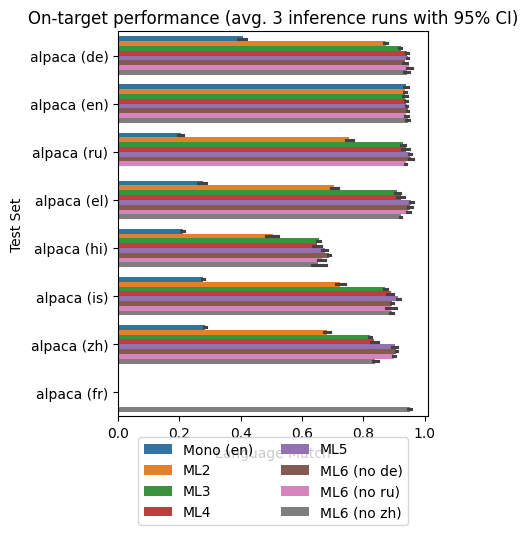

In [40]:
# plot bar plots of lang_match
fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='lang_match', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_title('On-target performance (avg. 3 inference runs with 95% CI)')
ax.set_xlabel('Language Match')
ax.set_ylabel('Test Set')

# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)

fig.savefig('data/plots/llama2_7b_lang_match.png', bbox_inches='tight', dpi=300)


In [14]:
# inspect off-target generations in output files

def get_generations(results_dir):
    dfs = []
    for generations_file in Path(results_dir).glob('*/*.jsonl'):
        # print(eval_file)
        df = pd.read_json(generations_file, lines=True)
        model_name, test_set, prompt, seed = parse_filename(generations_file)
        df['model_name'] = model_name
        df['test_set'] = test_set
        df['context'] = prompt
        df['seed'] = seed
        dfs.append(df)
        
    df = pd.concat(dfs, axis=0, ignore_index=False)

    # move input_file, model_name and seed to front
    cols = df.columns.tolist()
    cols.insert(0, cols.pop(cols.index('model_name')))
    cols.insert(1, cols.pop(cols.index('test_set')))
    cols.insert(2, cols.pop(cols.index('seed')))
    # cols.insert(0, df.ndex)
    df = df.reindex(columns=cols)

    return df

gen_df = get_generations(results_dir)
gen_df

,model_name,test_set,seed,prompt,system,finish_reason,source,secs,source_lang,system_lang,context
0,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie lauten die Namen einiger berüh...",Here are some famous actors who began their ca...,stop,"""Wie lauten die Namen einiger berühmter Schaus...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
1,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie haben die US-Bundesstaaten ihr...",Die Staaten der Vereinigten Staaten von Amerik...,length,"""Wie haben die US-Bundesstaaten ihre Namen erh...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
2,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Hallo, meine Schwester und ihre Fr...",Sure! Kickball is a game that combines element...,stop,"""Hallo, meine Schwester und ihre Freundinnen m...",2.562441,deu_Latn,eng_Latn,guanaco_prompt
3,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Was sind einige coole Musikstücke ...","""Die 20er Jahre waren eine Zeit des wirtschaft...",stop,"""Was sind einige coole Musikstücke aus den 192...",2.562441,deu_Latn,deu_Latn,guanaco_prompt
4,llama_2_7b_hf_ml1_merged,alpaca_eval_instructions_de,0,"### Human: ""Wie verpacke ich ein Geschenk orde...","""Ein Geschenk verpacken ist eine wichtige Sach...",stop,"""Wie verpacke ich ein Geschenk ordentlich?""",2.562441,deu_Latn,deu_Latn,guanaco_prompt
...,...,...,...,...,...,...,...,...,...,...,...
800,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。### ...,"[推荐视频]\n\n<iframe width=""560"" height=""315"" src...",stop,为一段YouTube视频撰写剧本，探索爵士乐的历史和文化意义。,3.112936,NaN,NaN,guanaco_prompt
801,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和...,![](https://cdn-images-1.medium.com/max/1600/1...,stop,撰写一篇有趣的旅行博客文章，介绍最近去夏威夷的旅行，重点突出文化体验和必看景点。,3.112936,NaN,NaN,guanaco_prompt
802,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效...,电影《黑洞之魂》简介\n\n《黑洞之魂》是一部2021年上映的科幻电影，由迈克尔·杰克逊导演...,stop,为一部最近上映的科幻电影撰写一个引人入胜的影评，讨论其剧情、角色和特效。,3.112936,NaN,NaN,guanaco_prompt
803,llama_2_7b_hf_zh_merged,alpaca_eval_instructions_zh,723,### Human: 为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。### Assi...,[一句话简介]\n\n我们将讨论流媒体平台对音乐产业的影响，并对此进行探讨。我们将从三个角度...,stop,为一集讨论流媒体平台对音乐产业影响的播客脚本进行构建。,3.112936,NaN,NaN,guanaco_prompt


In [15]:
# def inspect_longer_strings(text):
#     # escape newlines
#     text = text.replace('\n', '\\n')
#     text_ = text[:100]
#     if len(text) > len(text_):
#         text_ += '...'
#     return text_

# for i, row in gen_df.iterrows():
#     expected_lang = row['test_set'][-2:]
#     # print(expected_lang)
#     if row['system_lang'] != expected_lang:
#         print(i, inspect_longer_strings(row['source']))
#         print(row['system_lang'], inspect_longer_strings(row['system']))
#         print('*****')
#         # break

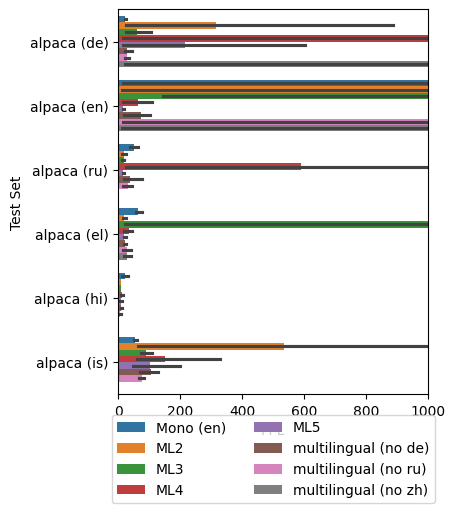

In [16]:
# plot bar plots of lang_match

fig, ax = plt.subplots(figsize=(4, 5))

sns.barplot(x='ppl', y='test_set', hue='model_name', errorbar='ci', orient='h', data=df, ax=ax)

ax.set_xlabel('PPL')
ax.set_ylabel('Test Set')

ax.set_xlim(0, 1000)
# legend at bottom
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=2)



In [ ]:
# # sort models given the order in name_map
# model_names = df['model_name'].unique()
# ordered_model_names = sorted(model_names, key=lambda x: list(name_map.values()).index(x))
# print(ordered_model_names)
# ordered_test_sets = sorted(df['test_set'].unique())
# print(ordered_test_sets)
# ordered_seeds = sorted(df['seed'].unique())
# print(ordered_seeds)

# def apply_sort(df):

#     df['model_name'] = pd.Categorical(df['model_name'], ordered_model_names)

#     df['context'] = pd.Categorical(df['context'], ordered_contexts)

#     df = df.sort_values(by=['test_set', 'model_name', 'context', 'seed'])

#     # Convert the columns back to their original data types
#     df['model_name'] = df['model_name'].astype(str)
#     df['context'] = df['context'].astype(str)
        
#     df = df.reset_index(drop=True)

#     return df

# # drop columns containing any NaN values
# # df = df.dropna(axis=1, how='any')

# # sort dataframe
# df = apply_sort(df)

# # store sort order
# custom_sort_index = df.index.tolist()
# df['idx'] = custom_sort_index
# print(df.columns)
# df.head(4)